<a href="https://colab.research.google.com/github/zxyao5148/STAT3612_2023_1A_GroupProject/blob/main/RNN_Transformer/Bi_LSTM_median_adj_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates how to do timeseries classification using RNN models (Simple RNN, LSTM, and GRU).

Reference: https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Load the dataset

In [ ]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split

# Raw URLs for the CSV files
train_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/train/train_valid_median.csv"
test_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/test/test_median.csv"

# Download the CSV files
train_csv = requests.get(train_url).text
test_csv = requests.get(test_url).text

# Read the CSV files into pandas DataFrames
train_valid = pd.read_csv(StringIO(train_csv))
test = pd.read_csv(StringIO(test_csv))

train_valid['deathtime'] = np.where(train_valid['deathtime'].notnull(), 1, 0)
test['deathtime'] = np.where(test['deathtime'].notnull(), 1, 0)

x_train_valid = train_valid[['deathtime']].join(train_valid.iloc[:, 9:])
y_train_valid = train_valid.iloc[:, 8]

!wget https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/code_base/adjust_imbl.py
from adjust_imbl import adjust_imbl
x_train_valid, y_train_valid = adjust_imbl(x_train_valid, y_train_valid)

# with 80% of the data for training and 20% for validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=3612)

x_test = test[['deathtime']].join(test.iloc[:,8:])

--2023-11-17 16:47:15--  https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/code_base/adjust_imbl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927 [text/plain]
Saving to: ‘adjust_imbl.py’

adjust_imbl.py      100%[===================>]     927  --.-KB/s    in 0s      

2023-11-17 16:47:16 (51.6 MB/s) - ‘adjust_imbl.py’ saved [927/927]

Original dataset shape Counter({0: 9564, 1: 2032})
Resampled dataset shape Counter({0: 2032, 1: 2032})


In [ ]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_valid = x_valid.values.reshape((x_valid.shape[0], x_valid.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

# Reset the index of the y_train DataFrame
y_train = y_train.reset_index(drop=True)

# Shuffle the indices
idx = np.random.permutation(len(x_train))

# Reassign the values using the shuffled indices
x_train = x_train[idx]
y_train = y_train.iloc[idx]

## Build the model

The model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.


In [ ]:
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
import keras

#  Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
import keras
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
# Add a Bidirectional LSTM layer with return_sequences=True and L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1), kernel_regularizer=l2(0.01))))
# Add Batch Normalization
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Add another Bidirectional LSTM layer with return_sequences=False and activation function set to "tanh"
model.add(Bidirectional(LSTM(128, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01))))
# Add Batch Normalization
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

# Compile the model with a lower learning rate and use ReduceLROnPlateau for learning rate scheduling
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

print('model compiled')

# Define early stopping and learning rate reduction callbacks
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(factor=0.1, patience=5)]

# Print model summary
#print(model.summary())

# Train the model with a smaller batch size
history_LSTM = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=callbacks)

model compiled
Epoch 1/100
26/26 [==============================] - 29s 122ms/step - loss: 3.9245 - accuracy: 0.7459 - val_loss: 3.2281 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 1s 46ms/step - loss: 2.4670 - accuracy: 0.7779 - val_loss: 2.1988 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 40ms/step - loss: 1.6293 - accuracy: 0.7887 - val_loss: 1.6331 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 38ms/step - loss: 1.1880 - accuracy: 0.7887 - val_loss: 1.3332 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 38ms/step - loss: 0.9458 - accuracy: 0.7831 - val_loss: 1.1492 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 41ms/step - loss: 0.7913 - accuracy: 0.7868 - val_loss: 1.0605 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 

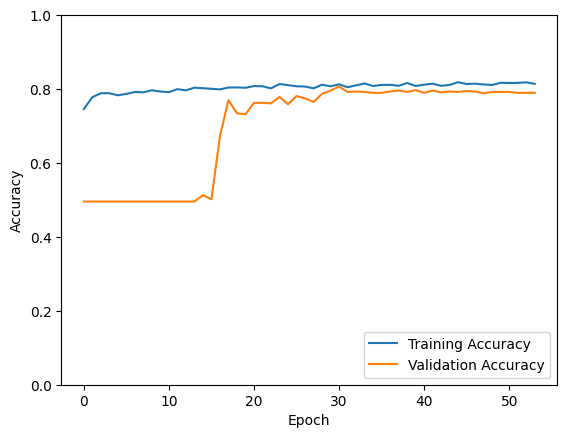

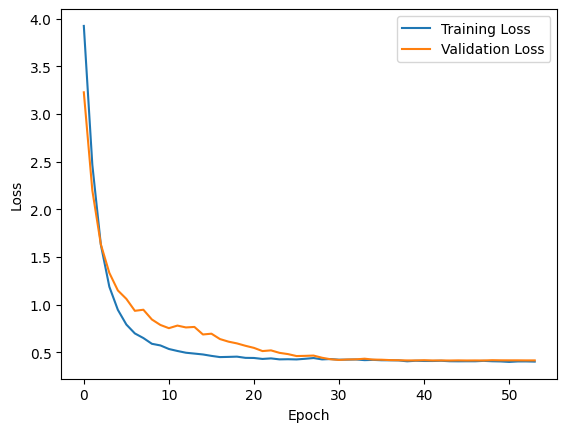

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history_LSTM.history['accuracy'], label='Training Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


##Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score

threshold = 0.5

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_valid_pred = model.predict(x_valid)
y_valid_pred_binary = (y_valid_pred > threshold).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred)

accuracy_valid = accuracy_score(y_valid, y_valid_pred_binary)
auc_valid = roc_auc_score(y_valid, y_valid_pred)

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')

print(f'Accuracy (valid): {accuracy_valid:.4f}')
print(f'AUC (valid): {auc_valid:.4f}')

26/26 [==============================] - 0s 9ms/step
Accuracy (train): 0.8148
AUC (train): 0.8664
Accuracy (valid): 0.7934
AUC (valid): 0.8540


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary, zero_division=1)
recall = recall_score(y_train, y_train_pred_binary, zero_division=1)
f1 = f1_score(y_train, y_train_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

# Calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_valid_pred_binary, zero_division=1)
recall = recall_score(y_valid, y_valid_pred_binary, zero_division=1)
f1 = f1_score(y_valid, y_valid_pred_binary, zero_division=1)

# Print with 4 digits limit
print("For validation set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

For training set:
Precision: 0.9622
Recall: 0.6562
F1 Score: 0.7803 

For validation set:
Precision: 0.9123
Recall: 0.6452
F1 Score: 0.7558


In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > threshold).astype(int)

92/92 [==============================] - 1s 9ms/step


In [ ]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>